In [1]:
# %%

device = "cuda:0"

In [2]:
# %%

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from monai.transforms import (
    Compose,
    Orientationd,
)
import torch

In [3]:
# %%

from typing import List, Tuple, Union
import numpy as np
import torch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    Orientationd,
    NormalizeIntensityd,
)

In [4]:
# %%

TRAIN_DATA_DIR = "./numpy-data"
TEST_DATA_DIR = "./data"

In [5]:
# %%

import json

copick_config_path = "./working/copick.config"

with open(copick_config_path) as f:
    copick_config = json.load(f)

copick_config["static_root"] = "./data/test/static"

copick_test_config_path = "copick_test.config"

with open(copick_test_config_path, "w") as outfile:
    json.dump(copick_config, outfile)

In [6]:
# %%

import copick

root = copick.from_file(copick_test_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

In [7]:
# %%

# Non-random transforms to be cached
inference_transforms = Compose(
    [
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        NormalizeIntensityd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
    ]
)

In [8]:
# %%

import cc3d

id_to_name = {
    1: "apo-ferritin",
    2: "beta-amylase",
    3: "beta-galactosidase",
    4: "ribosome",
    5: "thyroglobulin",
    6: "virus-like-particle",
}

# %% [markdown]

 # Version 2 with overlap

In [9]:
# %%


def calculate_patch_starts_with_overlap(
    dimension_size: int, patch_size: int, overlap: int
) -> List[int]:
    if dimension_size <= patch_size:
        return [0]

    num_patches = np.ceil(
        (dimension_size - overlap) / (patch_size - overlap) + 1
    ).astype(int)
    patch_starts = []
    for i in range(num_patches):
        pos = int(i * (patch_size - overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in patch_starts:
            patch_starts.append(pos)
    return patch_starts


def extract_3d_patches_overlap(
    arrays: List[np.ndarray],
    patch_sizes: Tuple[int, int, int],
    overlap_sizes: Tuple[int, int, int],
) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:

    patch_starts_x = calculate_patch_starts_with_overlap(
        arrays[0].shape[0], patch_sizes[0], overlap_sizes[0]
    )
    patch_starts_y = calculate_patch_starts_with_overlap(
        arrays[0].shape[1], patch_sizes[1], overlap_sizes[1]
    )
    patch_starts_z = calculate_patch_starts_with_overlap(
        arrays[0].shape[2], patch_sizes[2], overlap_sizes[2]
    )
    patch_size_d, patch_size_h, patch_size_w = patch_sizes
    patches = []
    coordinates = []
    for arr in arrays:
        for x in patch_starts_x:
            for y in patch_starts_y:
                for z in patch_starts_z:
                    patch = arr[
                        x : x + patch_size_d, y : y + patch_size_h, z : z + patch_size_w
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates

In [10]:
# %%


def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with minimal overlap to cover the entire dimension.

    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension

    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]

    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)

    if n_patches == 1:
        return [0]

    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)

    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)

    return positions


def extract_3d_patches_minimal_overlap(
    arrays: List[np.ndarray], patch_sizes: Tuple[int, int, int]
) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with minimal overlap to cover the entire array.

    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)

    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    patch_size_d, patch_size_h, patch_size_w = patch_sizes
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")

    # Verify all arrays have the same shape
    shape = arrays[0].shape
    D, H, W = shape

    m, n, l = shape
    patches = []
    coordinates = []

    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size_d)
    y_starts = calculate_patch_starts(n, patch_size_h)
    z_starts = calculate_patch_starts(l, patch_size_w)

    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x : x + patch_size_d, y : y + patch_size_h, z : z + patch_size_w
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates


# Note: I should probably averge the overlapping areas,
# but here they are just overwritten by the most recent one.


def reconstruct_array(
    patches: List[np.ndarray],
    coordinates: List[Tuple[int, int, int]],
    original_shape: Tuple[int, int, int],
) -> np.ndarray:
    """
    Reconstruct array from patches.

    Parameters:
    -----------
    patches : List[np.ndarray]
        List of patches to reconstruct from
    coordinates : List[Tuple[int, int, int]]
        Starting coordinates for each patch
    original_shape : Tuple[int, int, int]
        Shape of the original array

    Returns:
    --------
    np.ndarray
        Reconstructed array
    """
    reconstructed = np.zeros(
        original_shape, dtype=np.int64
    )  # To track overlapping regions

    patch_size = patches[0].shape[0]

    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[x : x + patch_size, y : y + patch_size, z : z + patch_size] = (
            patch
        )

    return reconstructed

In [11]:
# %%

import pandas as pd


def dict_to_df(coord_dict, experiment_name):
    """
    Convert dictionary of coordinates to pandas DataFrame.

    Parameters:
    -----------
    coord_dict : dict
        Dictionary where keys are labels and values are Nx3 coordinate arrays

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['x', 'y', 'z', 'label']
    """
    # Create lists to store data
    all_coords = []
    all_labels = []

    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))

    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)

    df = pd.DataFrame(
        {
            "experiment": experiment_name,
            "particle_type": all_labels,
            "x": all_coords[:, 0],
            "y": all_coords[:, 1],
            "z": all_coords[:, 2],
        }
    )

    return df

In [12]:
# %%

torch.set_float32_matmul_precision("medium")

# Check if CUDA is available and then count the GPUs
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
else:
    print("No GPU available. Running on CPU.")
devices = list(range(num_gpus))
print(devices)

Number of GPUs available: 2
[0, 1]


In [13]:
# %%

threshold = {
    "apo-ferritin": 0.05,
    "beta-amylase": 0.05,
    "beta-galactosidase": 0.05,
    "ribosome": 0.05,
    "thyroglobulin": 0.05,
    "virus-like-particle": 0.05,
}
threshold = list(threshold.values())
threshold = torch.tensor(threshold, device=device).reshape(6, 1, 1, 1)

In [14]:
# %%

from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

from utils.dataset import *
from utils.czii_helper import *

# %% [markdown]

 # with overlap

In [15]:
# %%

torch.cuda.empty_cache()

In [16]:
# %%

from typing import List, Tuple, Union


def extract_3d_patches_overlap_wo_data(
    arrays_shape: Tuple[int, int, int],
    patch_sizes: Tuple[int, int, int],
    overlap_sizes: Tuple[int, int, int],
) -> List[Tuple[int, int, int]]:

    patch_starts_x = calculate_patch_starts_with_overlap(
        arrays_shape[0], patch_sizes[0], overlap_sizes[0]
    )
    patch_starts_y = calculate_patch_starts_with_overlap(
        arrays_shape[1], patch_sizes[1], overlap_sizes[1]
    )
    patch_starts_z = calculate_patch_starts_with_overlap(
        arrays_shape[2], patch_sizes[2], overlap_sizes[2]
    )
    patch_size_d, patch_size_h, patch_size_w = patch_sizes
    coordinates = []
    for x in patch_starts_x:
        for y in patch_starts_y:
            for z in patch_starts_z:
                coordinates.append((x, y, z))

    return coordinates

In [17]:
# %%

import os


MODE = "local"

valid_dir = "/root/codes/CryoET/data/train"
valid_id = [
    "TS_6_4",
]


def do_one_eval(truth, predict, threshold):
    P = len(predict)
    T = len(truth)

    if P == 0:
        hit = [[], []]
        miss = np.arange(T).tolist()
        fp = []
        metric = [P, T, len(hit[0]), len(miss), len(fp)]
        return hit, fp, miss, metric

    if T == 0:
        hit = [[], []]
        fp = np.arange(P).tolist()
        miss = []
        metric = [P, T, len(hit[0]), len(miss), len(fp)]
        return hit, fp, miss, metric

    # ---
    distance = predict.reshape(P, 1, 3) - truth.reshape(1, T, 3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss, t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp, p_index)].tolist()

    metric = [P, T, len(hit[0]), len(miss), len(fp)]  # for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df["experiment"].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(
            id, overlay_dir
        )  # =f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df["experiment"] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print("\r", id, p.name, end="", flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df["particle_type"] == p.name][
                ["x", "y", "z"]
            ].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius * 0.5)
            eval_df.append(
                dotdict(
                    id=id,
                    particle_type=p.name,
                    P=metric[0],
                    T=metric[1],
                    hit=metric[2],
                    miss=metric[3],
                    fp=metric[4],
                )
            )
    print("")
    eval_df = pd.DataFrame(eval_df)
    eval_df.drop(columns=["id"], inplace=True)
    gb = eval_df.groupby("particle_type").agg("sum")
    gb.loc[:, "precision"] = gb["hit"] / gb["P"]
    gb.loc[:, "precision"] = gb["precision"].fillna(0)
    gb.loc[:, "recall"] = gb["hit"] / gb["T"]
    gb.loc[:, "recall"] = gb["recall"].fillna(0)
    gb.loc[:, "f-beta4"] = (
        17 * gb["precision"] * gb["recall"] / (16 * gb["precision"] + gb["recall"])
    )
    gb.loc[:, "f-beta4"] = gb["f-beta4"].fillna(0)

    gb = gb.sort_values("particle_type").reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, "weight"] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb["f-beta4"] * gb["weight"]).sum() / gb["weight"].sum()
    return gb, lb_score


def compute_lb_6_4(submit_df, overlay_dir):
    valid_id = ["TS_6_4"]
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(
            id, overlay_dir
        )  # =f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df["experiment"] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print("\r", id, p.name, end="", flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df["particle_type"] == p.name][
                ["x", "y", "z"]
            ].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius * 0.5)
            eval_df.append(
                dotdict(
                    id=id,
                    particle_type=p.name,
                    P=metric[0],
                    T=metric[1],
                    hit=metric[2],
                    miss=metric[3],
                    fp=metric[4],
                )
            )
    print("")
    eval_df = pd.DataFrame(eval_df)
    eval_df.drop(columns=["id"], inplace=True)
    gb = eval_df.groupby("particle_type").agg("sum")
    gb.loc[:, "precision"] = gb["hit"] / gb["P"]
    gb.loc[:, "precision"] = gb["precision"].fillna(0)
    gb.loc[:, "recall"] = gb["hit"] / gb["T"]
    gb.loc[:, "recall"] = gb["recall"].fillna(0)
    gb.loc[:, "f-beta4"] = (
        17 * gb["precision"] * gb["recall"] / (16 * gb["precision"] + gb["recall"])
    )
    gb.loc[:, "f-beta4"] = gb["f-beta4"].fillna(0)

    gb = gb.sort_values("particle_type").reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, "weight"] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb["f-beta4"] * gb["weight"]).sum() / gb["weight"].sum()
    return gb, lb_score

In [18]:
# %%

import threading

lock = threading.Lock()


def build_weights(
    patch_sizes, overlap_sizes, EDGE_WEIGHT, mask_hard_cases=False, device="cuda:0"
):
    # overlap_sizes = (32, 32, 32)
    weights = torch.zeros(*patch_sizes, dtype=torch.half, device=device)
    weights += EDGE_WEIGHT
    weights[
        overlap_sizes[0] // 4 : patch_sizes[0] - overlap_sizes[0] // 4,
        overlap_sizes[1] // 4 : patch_sizes[1] - overlap_sizes[1] // 4,
        overlap_sizes[2] // 4 : patch_sizes[2] - overlap_sizes[2] // 4,
    ] += (
        1 - EDGE_WEIGHT
    )
    return weights


def infer(
    run,
    device_id,
    CERTAINTY_THRESHOLD=0.25,
    EDGE_WEIGHT=0.1,
    submit_df=None,
    model_list=None,
    patch_sizes_list=None,
    overlap_sizes=None,
    tomo_threshold=None,
    act_mode_list=None,
):
    with torch.no_grad():
        device = torch.device(f"cuda:{device_id}")
        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomogram(tomo_type).numpy()

        # tomo = inference_transforms({"image": tomo})["image"]

        # tomo_patches, coordinates = extract_3d_patches_overlap(
        #     [tomo], patch_sizes, overlap_sizes
        # )
        image = torch.tensor(tomo, device=device, dtype=torch.half)

        D, H, W = (184, 630, 630)
        coordinates_list = [
            extract_3d_patches_overlap_wo_data((D, H, W), patch_sizes, overlap_sizes)
            for patch_sizes in patch_sizes_list
        ]
        weights_list = [
            build_weights(patch_sizes, overlap_sizes, EDGE_WEIGHT, False, device)
            for patch_sizes in patch_sizes_list
        ]
        # coordinates = extract_3d_patches_overlap_wo_data(
        #     (D, H, W), patch_sizes, overlap_sizes
        # )
        probability = torch.zeros((5, D, H, W), device=device).half()
        count = torch.zeros((D, H, W), device=device).half()
        for idx, (model, patch_sizes, coordinates, weights) in enumerate(
            zip(model_list, patch_sizes_list, coordinates_list, weights_list)
        ):
            # weights = weights.to(device)
            for i in range(len(coordinates)):
                coor = coordinates[i]
                input_tensor_0 = image[
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ]
                input_tensor_0 = inference_transforms({"image": input_tensor_0})[
                    "image"
                ]  # (1, D, H, W)
                input_tensor_0 = torch.tensor(
                    input_tensor_0, dtype=torch.half
                ).unsqueeze(
                    0
                )  # input_tensor shape B,C,D,H,W
                input_tensor_90 = torch.rot90(input_tensor_0, 1, [3, 4])
                input_tensor_180 = torch.rot90(input_tensor_0, 2, [3, 4])
                input_tensor_270 = torch.rot90(input_tensor_0, 3, [3, 4])
                input_tensor_2 = torch.flip(input_tensor_0, [2])
                input_tensor_3 = torch.flip(input_tensor_0, [3])
                input_tensor_4 = torch.flip(input_tensor_0, [4])
                # input_tensor_270_2 = torch.flip(input_tensor_270, [2])
                _, _, patch_d, patch_h, patch_w = input_tensor_0.shape
                # coor = tomo_ds[i]["coord"]

                model_output_0 = model(input_tensor_0)
                model_output_90 = model(input_tensor_90)
                model_output_180 = model(input_tensor_180)
                model_output_270 = model(input_tensor_270)
                model_output_2 = model(input_tensor_2)
                model_output_3 = model(input_tensor_3)
                model_output_4 = model(input_tensor_4)

                model_output_90 = torch.rot90(model_output_90, 3, [3, 4])
                model_output_180 = torch.rot90(model_output_180, 2, [3, 4])
                model_output_270 = torch.rot90(model_output_270, 1, [3, 4])
                model_output_2 = torch.flip(model_output_2, [2])
                model_output_3 = torch.flip(model_output_3, [3])
                model_output_4 = torch.flip(model_output_4, [4])

                if act_mode_list and act_mode_list[idx] == "sigmoid":
                    probs = (
                        torch.nn.functional.sigmoid(model_output_0[0])
                        + torch.nn.functional.sigmoid(model_output_90[0])
                        + torch.nn.functional.sigmoid(model_output_180[0])
                        + torch.nn.functional.sigmoid(model_output_270[0])
                        + torch.nn.functional.sigmoid(model_output_2[0])
                        + torch.nn.functional.sigmoid(model_output_3[0])
                        + torch.nn.functional.sigmoid(model_output_4[0])
                    ) / 7
                else:
                    probs = (
                        torch.softmax(model_output_0[0], dim=0)
                        + torch.softmax(model_output_90[0], dim=0)
                        + torch.softmax(model_output_180[0], dim=0)
                        + torch.softmax(model_output_270[0], dim=0)
                        + torch.softmax(model_output_2[0], dim=0)
                        + torch.softmax(model_output_3[0], dim=0)
                        + torch.softmax(model_output_4[0], dim=0)
                    ) / 7
                # print("Max min mean")
                # print(probs.max())
                # print(probs.min())
                # print(probs.mean())
                probability[
                    0,
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ] += (
                    probs[1] * weights
                )
                probability[
                    -4:,
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ] += (
                    probs[-4:] * weights
                )
                count[
                    coor[0] : coor[0] + patch_sizes[0],
                    coor[1] : coor[1] + patch_sizes[1],
                    coor[2] : coor[2] + patch_sizes[2],
                ] += weights

            # weights = weights.to("cpu")

        probability = probability / count

        probability0 = probability
        probability1 = F.interpolate(
            probability0, scale_factor=0.5, mode="bilinear", align_corners=False
        )
        binary0 = (probability0 > CERTAINTY_THRESHOLD).data.cpu().numpy()
        binary1 = (probability1 > CERTAINTY_THRESHOLD).data.cpu().numpy()

        location = [np.empty((0, 3)) for i in range(6)]

        for c in [0]:
            componet = cc3d.connected_components(binary0[c])
            stats = cc3d.statistics(componet)
            zyx = stats["centroids"][1:] * 10.012444
            # zyx_large = zyx[stats["voxel_counts"][1:] > BLOB_THRESHOLD]
            if tomo_threshold:
                zyx = zyx[stats["voxel_counts"][1:] > tomo_threshold[c]]
            xyz = np.ascontiguousarray(zyx[:, ::-1])
            location[c] = xyz

        for c in [2, 3, 4, 5]:
            componet = cc3d.connected_components(binary1[c - 1])
            stats = cc3d.statistics(componet)
            zyx = stats["centroids"][1:] * 10.012444 * [[1, 2, 2]]
            # zyx_large = zyx[stats["voxel_counts"][1:] > int(BLOB_THRESHOLD // 4)]
            if tomo_threshold:
                zyx = zyx[stats["voxel_counts"][1:] > tomo_threshold[c]]
            xyz = np.ascontiguousarray(zyx[:, ::-1])
            location[c] = xyz
        print("location", np.concatenate(location).shape)
        for class_id, name in id_to_name.items():
            class_id = int(class_id) - 1
            """pd.DataFrame(
            {
                "experiment": id,
                "particle_type": name,
                "x": xyz[:, 0],
                "y": xyz[:, 1],
                "z": xyz[:, 2],
            }"""
            submit_df.append(
                pd.DataFrame(
                    {
                        "experiment": run.name,
                        "particle_type": name,
                        "x": location[class_id][:, 0],
                        "y": location[class_id][:, 1],
                        "z": location[class_id][:, 2],
                    }
                )
            )


# def thread_infer(
#     run_list,
#     device_id,
#     CERTAINTY_THRESHOLD=0.25,
#     EDGE_WEIGHT=0.1,
#     submit_df=None,
#     model_list=None,
#     patch_sizes_list=None,
#     overlap_sizes=None,
#     tomo_threshold=None,
# ):
#     for run in run_list:
#         infer(
#             run,
#             device_id,
#             CERTAINTY_THRESHOLD,
#             EDGE_WEIGHT,
#             submit_df,
#             model_list,
#             patch_sizes_list,
#             overlap_sizes,
#             tomo_threshold,
#         )
def thread_infer(
    run_list,
    device_id,
    CERTAINTY_THRESHOLD=0.25,
    EDGE_WEIGHT=0.1,
    submit_df=None,
    model_list=None,
    patch_sizes_list=None,
    overlap_sizes=None,
    tomo_threshold=None,
    act_mode_list=None,
):
    while True:
        with lock:
            if len(run_list) == 0:
                break
            run = run_list.pop()
        infer(
            run,
            device_id,
            CERTAINTY_THRESHOLD,
            EDGE_WEIGHT,
            submit_df,
            model_list,
            patch_sizes_list,
            overlap_sizes,
            tomo_threshold,
            act_mode_list,
        )

# Choise the version

In [19]:
# %%

path_dir = "./lightning_logs/version_412/checkpoints"
path_list = []
for fname in os.listdir(path_dir):
    if ".ckpt" in fname and "last" not in fname:
        path_list.append(os.path.join(path_dir, fname))
epoch_list = [path.split("=")[1].split("-")[0] for path in path_list]
epoch_list = [int(epoch) for epoch in epoch_list]
path_list.sort(key=lambda x: int(x.split("=")[1].split("-")[0]))
path_list = path_list[-20:]

In [20]:
# %%

test_name = ["TS_6_4", "TS_5_4", "TS_69_2"]

In [21]:
# %%

import monai

unet_3d = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
)
segresnet = monai.networks.nets.SegResNet(
    in_channels=1,
    out_channels=6,
    dropout_prob=0.1,
    upsample_mode="deconv",
)
from models.model2 import Net

unet2e3d = Net(
    out_channels=6,
    arch="resnet18d",
    decoder_dim=[80, 80, 64, 32, 16],
    pretrained=False,
)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch=229-val_loss=0.60-val_metric=0.49-step=5520.ckpt
location (398, 3)
location (267, 3)
location (268, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  271  139  130     9  141   0.479705  0.935252   
1         beta-amylase    0   31    0    31    0   0.000000  0.000000   
2   beta-galactosidase  216   40   32     8  184   0.148148  0.800000   
3             ribosome  214  142  126    16   88   0.588785  0.887324   
4        thyroglobulin  202   94   76    18  126   0.376238  0.808511   
5  virus-like-particle   30   30   28     2    2   0.933333  0.933333   

    f-beta4  weight  
0  0.885772       1  
1  0.000000       0  
2  0.635514       2  
3  0.861625       1  
4  0.757327       2  
5  0.933333       1  
lb_score: 0.7809160251639691
['TS_6_4']
 TS_6_4 virus-like-particle

  5%|▌         | 1/20 [00:30<09:40, 30.53s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  137  58   56     2  81   0.408759  0.965517  0.893897   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   74  12   10     2  64   0.135135  0.833333  0.639098   
3             ribosome  113  74   63    11  50   0.557522  0.851351  0.825752   
4        thyroglobulin   65  30   21     9  44   0.323077  0.700000  0.655046   
5  virus-like-particle    9  10    8     2   1   0.888889  0.800000  0.804734   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7303813440056138

epoch=234-val_loss=0.59-val_metric=0.50-step=5640.ckpt
location (349, 3)
location (245, 3)
location (263, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  313  139  132     7  181   0.421725  0.949640 

 10%|█         | 2/20 [01:00<09:08, 30.48s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  138  58   57     1  81   0.413043  0.982759  0.909006   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   67  12   11     1  56   0.164179  0.916667  0.722008   
3             ribosome  101  74   63    11  38   0.623762  0.851351  0.833463   
4        thyroglobulin   36  30   16    14  20   0.444444  0.533333  0.527132   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7076175033919423

epoch=239-val_loss=0.56-val_metric=0.52-step=5760.ckpt
location (330, 3)
location (265, 3)
location (280, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  258  139  129    10  129   0.500000  0.928058 

 15%|█▌        | 3/20 [01:31<08:37, 30.43s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  102  58   56     2  46   0.549020  0.965517  0.924272   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   67  12   11     1  56   0.164179  0.916667  0.722008   
3             ribosome  108  74   65     9  43   0.601852  0.878378  0.855263   
4        thyroglobulin   46  30   19    11  27   0.413043  0.633333  0.614068   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7377517398570076

epoch=244-val_loss=0.57-val_metric=0.52-step=5880.ckpt
location (425, 3)
location (296, 3)
location (312, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  248  139  130     9  118   0.524194  0.935252 

 20%|██        | 4/20 [02:01<08:07, 30.45s/it]


         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  123  58   56     2   67   0.455285  0.965517   
1         beta-amylase    0   9    0     9    0   0.000000  0.000000   
2   beta-galactosidase  114  12   10     2  104   0.087719  0.833333   
3             ribosome  111  74   64    10   47   0.576577  0.864865   
4        thyroglobulin   70  30   20    10   50   0.285714  0.666667   
5  virus-like-particle    7  10    7     3    0   1.000000  0.700000   

    f-beta4  weight  
0  0.905804       1  
1  0.000000       0  
2  0.555556       2  
3  0.840154       1  
4  0.618182       2  
5  0.712575       1  
lb_score_6_4: 0.6865725763032413

epoch=249-val_loss=0.57-val_metric=0.52-step=6000.ckpt
location (316, 3)
location (214, 3)
location (214, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  222  139  132     7   90   0.594595  0.

 25%|██▌       | 5/20 [02:32<07:35, 30.39s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  101  58   57     1  44   0.564356  0.982759  0.941691   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   10  12    4     8   6   0.400000  0.333333  0.336634   
3             ribosome  115  74   64    10  51   0.556522  0.864865  0.837567   
4        thyroglobulin   82  30   23     7  59   0.280488  0.766667  0.695730   
5  virus-like-particle    8  10    8     2   0   1.000000  0.800000  0.809524   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6647869332280025

epoch=254-val_loss=0.57-val_metric=0.52-step=6120.ckpt
location (362, 3)
location (257, 3)
location (272, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  299  139  131     8  168   0.438127  0.942446 

 30%|███       | 6/20 [03:02<07:05, 30.37s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  132  58   56     2  76   0.424242  0.965517  0.898113   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   27  12    6     6  21   0.222222  0.500000  0.465753   
3             ribosome  117  74   65     9  52   0.555556  0.878378  0.849347   
4        thyroglobulin   76  30   22     8  54   0.289474  0.733333  0.672662   
5  virus-like-particle   10  10    8     2   2   0.800000  0.800000  0.800000   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6891843506125103

epoch=259-val_loss=0.57-val_metric=0.52-step=6240.ckpt
location (393, 3)
location (267, 3)
location (275, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  251  139  132     7  119   0.525896  0.949640 

 35%|███▌      | 7/20 [03:32<06:34, 30.34s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  129  58   57     1  72   0.441860  0.982759  0.916746   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   78  12   10     2  68   0.128205  0.833333  0.629630   
3             ribosome  105  74   64    10  41   0.609524  0.864865  0.844065   
4        thyroglobulin   73  30   21     9  52   0.287671  0.700000  0.645570   
5  virus-like-particle    8  10    8     2   0   1.000000  0.800000  0.809524   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7315332831764062

epoch=264-val_loss=0.56-val_metric=0.53-step=6360.ckpt
location (308, 3)
location (214, 3)
location (216, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  258  139  134     5  124   0.519380  0.964029 

 40%|████      | 8/20 [04:02<06:03, 30.30s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  117  58   58     0  59   0.495726  1.000000  0.943541   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   36  12    9     3  27   0.250000  0.750000  0.671053   
3             ribosome  107  74   64    10  43   0.598131  0.864865  0.842758   
4        thyroglobulin   40  30   16    14  24   0.400000  0.533333  0.523077   
5  virus-like-particle    8  10    8     2   0   1.000000  0.800000  0.809524   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7120115915681514

epoch=269-val_loss=0.55-val_metric=0.54-step=6480.ckpt
location (355, 3)
location (244, 3)
location (238, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  288  139  132     7  156   0.458333  0.949640 

 45%|████▌     | 9/20 [04:33<05:33, 30.31s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  128  58   57     1  71   0.445312  0.982759  0.917614   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   49  12    9     3  40   0.183673  0.750000  0.634855   
3             ribosome  111  74   64    10  47   0.576577  0.864865  0.840154   
4        thyroglobulin   59  30   21     9  38   0.355932  0.700000  0.662338   
5  virus-like-particle    8  10    8     2   0   1.000000  0.800000  0.809524   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7373823934693821

epoch=274-val_loss=0.54-val_metric=0.54-step=6600.ckpt
location (292, 3)
location (210, 3)
location (204, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  253  139  135     4  118   0.533597  0.971223 

 50%|█████     | 10/20 [05:03<05:03, 30.31s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  105  58   58     0  47   0.552381  1.000000  0.954501   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   30  12    8     4  22   0.266667  0.666667  0.612613   
3             ribosome  104  74   64    10  40   0.615385  0.864865  0.844720   
4        thyroglobulin   46  30   16    14  30   0.347826  0.533333  0.517110   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6816060795456779

epoch=279-val_loss=0.57-val_metric=0.52-step=6720.ckpt
location (333, 3)
location (219, 3)
location (240, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  306  139  133     6  173   0.434641  0.956835 

 55%|█████▌    | 11/20 [05:33<04:32, 30.32s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  135  58   58     0  77   0.429630  1.000000  0.927563   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   32  12    8     4  24   0.250000  0.666667  0.607143   
3             ribosome  116  74   64    10  52   0.551724  0.864865  0.836923   
4        thyroglobulin   42  30   18    12  24   0.428571  0.600000  0.586207   
5  virus-like-particle    8  10    8     2   0   1.000000  0.800000  0.809524   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7086728419093831

epoch=284-val_loss=0.57-val_metric=0.52-step=6840.ckpt
location (281, 3)
location (184, 3)
location (177, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss  fp  precision    recall  \
0         apo-ferritin  221  139  132     7  89   0.597285  0.949640   

 60%|██████    | 12/20 [06:04<04:02, 30.33s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin   94  58   57     1  37   0.606383  0.982759  0.948141   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   35  12    8     4  27   0.228571  0.666667  0.599119   
3             ribosome  104  74   63    11  41   0.605769  0.851351  0.831522   
4        thyroglobulin   41  30   16    14  25   0.390244  0.533333  0.522073   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6763744640583746

epoch=289-val_loss=0.57-val_metric=0.52-step=6960.ckpt
location (333, 3)
location (216, 3)
location (204, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  231  139  131     8  100   0.567100  0.942446 

 65%|██████▌   | 13/20 [06:34<03:32, 30.35s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  108  58   56     2  52   0.518519  0.965517  0.918919   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   61  12    8     4  53   0.131148  0.666667  0.537549   
3             ribosome  103  74   65     9  38   0.631068  0.878378  0.858586   
4        thyroglobulin   54  30   17    13  37   0.314815  0.566667  0.541199   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6639393493969636

epoch=294-val_loss=0.53-val_metric=0.55-step=7080.ckpt
location (320, 3)
location (206, 3)
location (211, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss  fp  precision    recall  \
0         apo-ferritin  230  139  133     6  97   0.578261  0.956835   

 70%|███████   | 14/20 [07:05<03:02, 30.35s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  107  58   58     0  49   0.542056  1.000000  0.952657   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   41  12   10     2  31   0.243902  0.833333  0.729614   
3             ribosome  109  74   65     9  44   0.596330  0.878378  0.854602   
4        thyroglobulin   53  30   18    12  35   0.339623  0.600000  0.574109   
5  virus-like-particle   10  10    8     2   2   0.800000  0.800000  0.800000   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7449576871620059

epoch=299-val_loss=0.55-val_metric=0.54-step=7200.ckpt
location (313, 3)
location (215, 3)
location (218, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  232  139  131     8  101   0.564655  0.942446 

 75%|███████▌  | 15/20 [07:35<02:31, 30.35s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin   98  58   56     2  42   0.571429  0.965517  0.927875   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   28  12    7     5  21   0.250000  0.583333  0.540909   
3             ribosome  108  74   65     9  43   0.601852  0.878378  0.855263   
4        thyroglobulin   72  30   21     9  51   0.291667  0.700000  0.646739   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6958585277923718

epoch=304-val_loss=0.55-val_metric=0.53-step=7320.ckpt
location (289, 3)
location (188, 3)
location (196, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss  fp  precision    recall  \
0         apo-ferritin  215  139  132     7  83   0.613953  0.949640   

 80%|████████  | 16/20 [08:05<02:01, 30.35s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin   95  58   58     0  37   0.610526  1.000000  0.963832   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   30  12    7     5  23   0.233333  0.583333  0.536036   
3             ribosome  108  74   64    10  44   0.592593  0.864865  0.842105   
4        thyroglobulin   49  30   18    12  31   0.367347  0.600000  0.578450   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6782119805073036

epoch=309-val_loss=0.57-val_metric=0.52-step=7440.ckpt
location (295, 3)
location (192, 3)
location (169, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  236  139  132     7  104   0.559322  0.949640 

 85%|████████▌ | 17/20 [08:36<01:31, 30.36s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  107  58   57     1  50   0.532710  0.982759  0.936232   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   25  12    9     3  16   0.360000  0.750000  0.705069   
3             ribosome   99  74   64    10  35   0.646465  0.864865  0.848012   
4        thyroglobulin   57  30   19    11  38   0.333333  0.633333  0.601490   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7299909956865152

epoch=314-val_loss=0.54-val_metric=0.54-step=7560.ckpt
location (314, 3)
location (212, 3)
location (222, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  242  139  134     5  108   0.553719  0.964029 

 90%|█████████ | 18/20 [09:06<01:00, 30.35s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  104  58   58     0  46   0.557692  1.000000  0.955426   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   44  12   11     1  33   0.250000  0.916667  0.792373   
3             ribosome  102  74   62    12  40   0.607843  0.837838  0.819596   
4        thyroglobulin   55  30   19    11  36   0.345455  0.633333  0.603738   
5  virus-like-particle    9  10    8     2   1   0.888889  0.800000  0.804734   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.7674254468625444

epoch=319-val_loss=0.56-val_metric=0.53-step=7680.ckpt
location (300, 3)
location (204, 3)
location (200, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  253  139  133     6  120   0.525692  0.956835 

 95%|█████████▌| 19/20 [09:36<00:30, 30.35s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  115  58   58     0  57   0.504348  1.000000  0.945350   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   29  12    7     5  22   0.241379  0.583333  0.538462   
3             ribosome  104  74   64    10  40   0.615385  0.864865  0.844720   
4        thyroglobulin   43  30   15    15  28   0.348837  0.500000  0.487572   
5  virus-like-particle    9  10    8     2   1   0.888889  0.800000  0.804734   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6638386653044546

epoch=324-val_loss=0.58-val_metric=0.51-step=7800.ckpt
location (280, 3)
location (189, 3)
location (186, 3)
['TS_6_4', 'TS_69_2', 'TS_5_4']
 TS_5_4 virus-like-particlee
         particle_type    P    T  hit  miss  fp  precision    recall  \
0         apo-ferritin  192  139  131     8  61   0.682292  0.942446   

100%|██████████| 20/20 [10:07<00:00, 30.36s/it]


         particle_type    P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin   83  58   56     2  27   0.674699  0.965517  0.941642   
1         beta-amylase    0   9    0     9   0   0.000000  0.000000  0.000000   
2   beta-galactosidase   41  12    9     3  32   0.219512  0.750000  0.656652   
3             ribosome  111  74   64    10  47   0.576577  0.864865  0.840154   
4        thyroglobulin   38  30   16    14  22   0.421053  0.533333  0.525097   
5  virus-like-particle    7  10    7     3   0   1.000000  0.700000  0.712575   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score_6_4: 0.6939812857645019



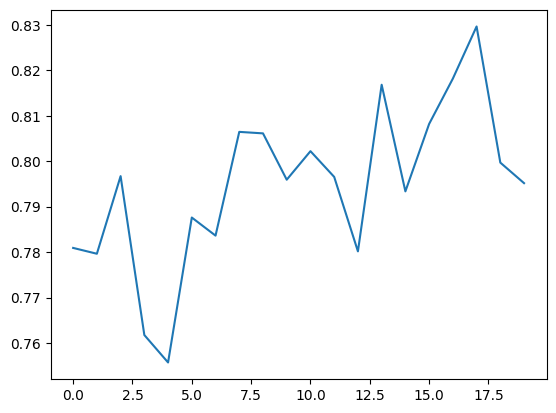

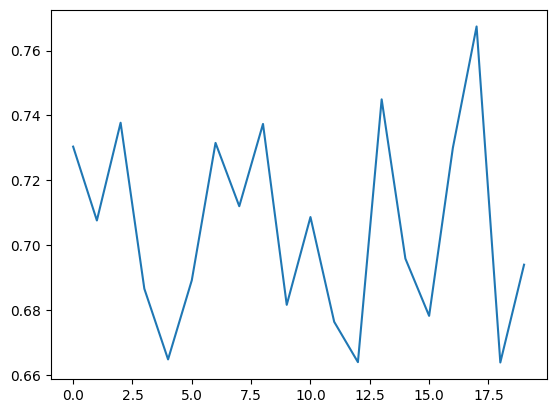

In [22]:
# %%

import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

CERTAINTY_THRESHOLD = 0.15
EDGE_WEIGHT = 0.1

threshold = {
    "apo-ferritin": 0.3,
    "beta-amylase": 0.3,
    "beta-galactosidase": 0.5,
    "ribosome": 0.3,
    "thyroglobulin": 0.6,
    "virus-like-particle": 0.3,
}
threshold = list(threshold.values())
threshold = torch.tensor(threshold, device=device).reshape(6, 1, 1, 1)

patch_sizes = [128, 384, 384]
# patch_sizes = [120, 352, 352]
overlap_sizes = [32, 32, 32]
BLOB_THRESHOLD = 10
classes = [1, 2, 3, 4, 5, 6]
#     ckpt = torch.load(path)
#     state_dict_ = ckpt["state_dict"]
#     state_dict = {}
#     for k in state_dict_.keys():
#         if "model." in k:
#             state_dict[k[6:]] = state_dict_[k]
lb_score_list = []
lb_score_list_6_4 = []
for path in tqdm(path_list):
    print(path.split("/")[-1])
    # model = Model2D.load_from_checkpoint(path, map_location="cpu", strict=False)
    ckpt = torch.load(path)
    state_dict_ = ckpt["state_dict"]
    state_dict = {}
    for k in state_dict_.keys():
        if "model." in k:
            state_dict[k[6:]] = state_dict_[k]
    try:
        unet_3d.load_state_dict(state_dict)
        model = unet_3d
    except:
        try:
            segresnet.load_state_dict(state_dict)
            model = segresnet
        except:
            unet2e3d.load_state_dict(state_dict)
            model = unet2e3d
    model = model.to(device).eval().half()
    model_list = [model]
    submit_df = []
    patch_sizes_list = [[128, 384, 384]]
    overlap_sizes = [32, 32, 32]
    tomo_threshold = [2, 2, 2, 5, 5, 5]
    run_list = root.runs
    run_list = [run for run in run_list if run.name in test_name]
    thread_infer(
        run_list,
        0,
        CERTAINTY_THRESHOLD,
        EDGE_WEIGHT,
        submit_df,
        model_list,
        patch_sizes_list,
        overlap_sizes,
        tomo_threshold,
    )
    submit_df = pd.concat(submit_df)
    submit_df.insert(loc=0, column="id", value=np.arange(len(submit_df)))

    submit_df.to_csv("submission.csv", index=False)

    submit_df = pd.read_csv(
        "submission.csv"
        # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
    )
    try:
        gb, lb_score = compute_lb(submit_df, f"{valid_dir}/overlay/ExperimentRuns")
        print(gb)
        print("lb_score:", lb_score)
        lb_score_list.append(lb_score)
        gb_6_4, lb_score_6_4 = compute_lb_6_4(
            submit_df, f"{valid_dir}/overlay/ExperimentRuns"
        )
        print(gb_6_4)
        print("lb_score_6_4:", lb_score_6_4)
        lb_score_list_6_4.append(lb_score_6_4)

    except:
        pass
    print("")
    model = model.to("cpu")
    del model
    torch.cuda.empty_cache()

import matplotlib.pyplot as plt

plt.plot(lb_score_list)
plt.show()
plt.plot(lb_score_list_6_4)
plt.show()